In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [3]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

# Download Titanic dataset
api.competition_download_files('titanic', path='./titanic_dataset')

# Unzip the downloaded files
import zipfile

with zipfile.ZipFile('./titanic_dataset/titanic.zip', 'r') as zip_ref:
    zip_ref.extractall('./titanic_dataset')


In [4]:
train_data = pd.read_csv('./titanic_dataset/train.csv')
test_data = pd.read_csv('./titanic_dataset/test.csv')

# Display the first few rows of the training data
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**4. Data Cleaning and Preprocessing**  
Handling Missing Values:

In [5]:
# Check for missing values
missing_values = train_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Fill missing values in 'Age' with median and 'Embarked' with mode
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

# Check if 'Cabin' column exists and drop it if present
if 'Cabin' in train_data.columns:
    train_data.drop(columns=['Cabin'], inplace=True)

# Confirm that there are no more missing values
missing_values_after = train_data.isnull().sum()
print("Missing values after cleaning:\n", missing_values_after)


Missing values in each column:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Missing values after cleaning:
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


**5. Data Visualization**  
Survival Distribution:

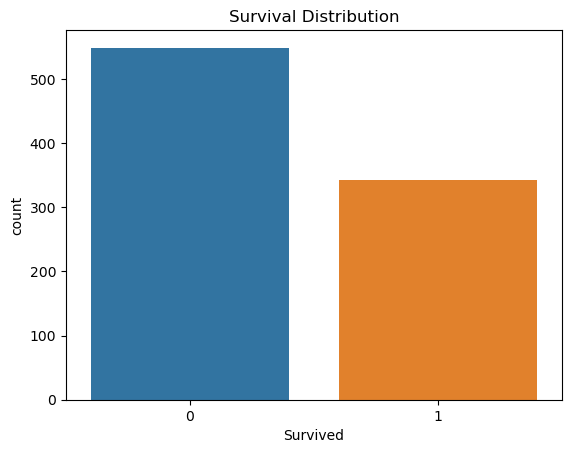

In [6]:
# Plotting the survival distribution
sns.countplot(x='Survived', data=train_data)
plt.title('Survival Distribution')
plt.show()


**Feature Distributions:**

C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


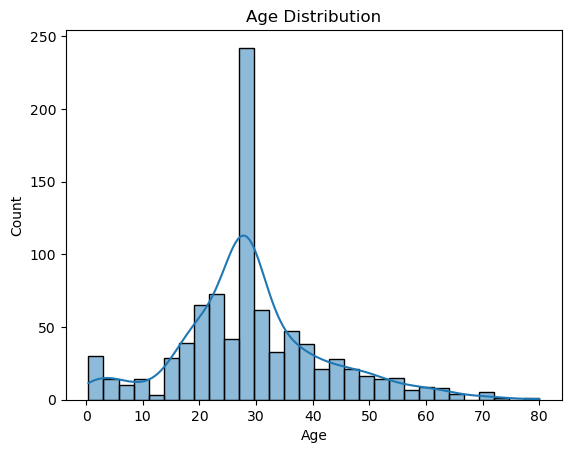

In [7]:
# Plotting the distribution of passengers' age
sns.histplot(train_data['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

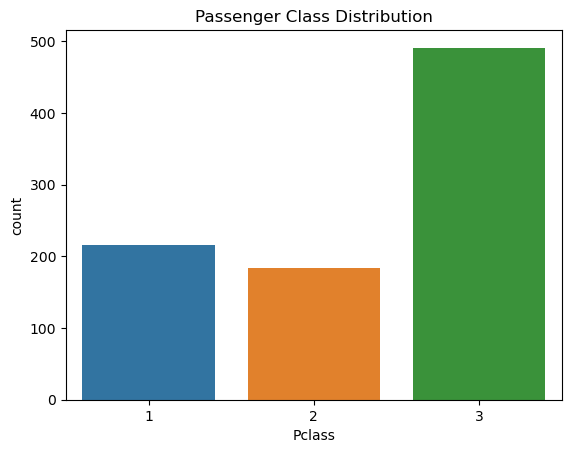

In [8]:
# Plotting the distribution of passengers by class
sns.countplot(x='Pclass', data=train_data)
plt.title('Passenger Class Distribution')
plt.show()


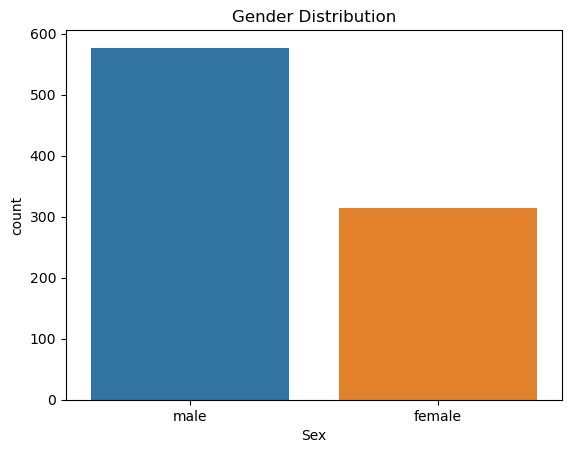

In [9]:
# Plotting the distribution of passengers by gender
sns.countplot(x='Sex', data=train_data)
plt.title('Gender Distribution')
plt.show()


**Correlations:**

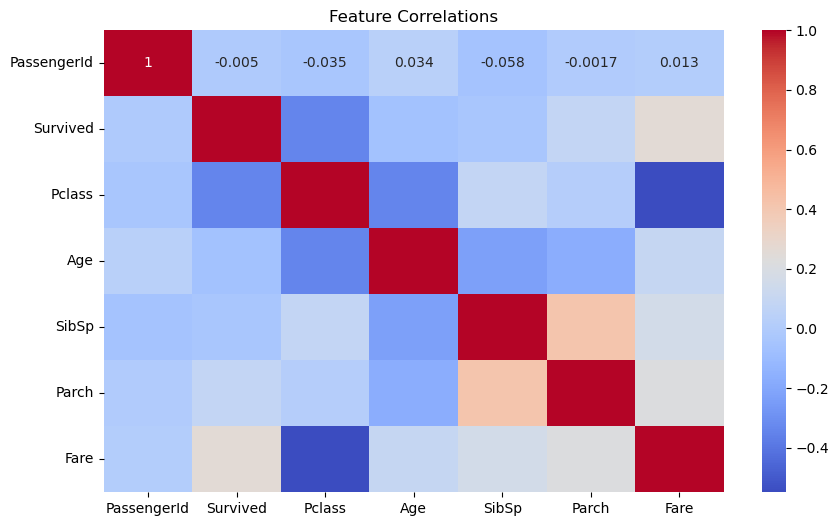

In [11]:
# Select only numeric columns for correlation matrix
numeric_cols = train_data.select_dtypes(include=[np.number])

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()


**Feature Engineering**  
Creating New Features  
Family Size

In [13]:
# Creating FamilySize feature
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1

In [14]:
# Creating IsAlone feature
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)

**Extracting Titles from Names**

In [15]:
# Extracting titles from the Name column
train_data['Title'] = train_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Grouping rare titles
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train_data['Title'] = train_data['Title'].replace(rare_titles, 'Rare')
train_data['Title'] = train_data['Title'].replace(['Mlle', 'Ms'], 'Miss')
train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs')

**Data Preprocessing**  
Encoding Categorical Variables

In [16]:
# Encoding categorical features
label_encoder = LabelEncoder()
train_data['Sex'] = label_encoder.fit_transform(train_data['Sex'])
train_data['Embarked'] = label_encoder.fit_transform(train_data['Embarked'])
train_data['Title'] = label_encoder.fit_transform(train_data['Title'])

**Selecting Relevant Features**

In [17]:
# Selecting relevant features for the model
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title']
X = train_data[features]
y = train_data['Survived']

Splitting the Data

In [18]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Standardization

In [19]:
# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

**Model Training**  
Decision Tree Classifier

In [20]:
# Training a Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Random Forest Classifier

In [21]:
# Training a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Model Evaluation**  
Decision Tree Evaluation

In [22]:
# Predicting and evaluating the Decision Tree model
y_pred_dt = dt_model.predict(X_val)
print("Decision Tree Accuracy:", accuracy_score(y_val, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_dt))
print("Classification Report:\n", classification_report(y_val, y_pred_dt))

Decision Tree Accuracy: 0.7821229050279329
Confusion Matrix:
 [[83 22]
 [17 57]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       105
           1       0.72      0.77      0.75        74

    accuracy                           0.78       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.78      0.78       179



Random Forest Evaluation

In [23]:
# Predicting and evaluating the Random Forest model
y_pred_rf = rf_model.predict(X_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))
print("Classification Report:\n", classification_report(y_val, y_pred_rf))

Random Forest Accuracy: 0.8379888268156425
Confusion Matrix:
 [[91 14]
 [15 59]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86       105
           1       0.81      0.80      0.80        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

